In [186]:
%matplotlib inline

from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import yfinance as yf

plt.rc("figure", figsize=(16, 8))
plt.rc("font", size=15)

In [187]:
class TVRegression(sm.tsa.statespace.MLEModel):
    def __init__(self, y_t, x_t):
        exog = np.c_[x_t]  # shaped nobs x 2
        
        super(TVRegression, self).__init__(
            endog=y_t, exog=exog, k_states=1, initialization="diffuse"
        )

        # Since the design matrix is time-varying, it must be
        # shaped k_endog x k_states x nobs
        # Notice that exog.T is shaped k_states x nobs, so we
        # just need to add a new first axis with shape 1

        self.ssm["design"] = exog.T[np.newaxis, :, :]  # shaped 1 x 2 x nobs
        self.ssm["selection"] = np.eye(self.k_states)
        self.ssm["transition"] = np.eye(self.k_states)

        # Which parameters need to be positive?
        self.positive_parameters = slice(1, 4)

    @property
    def param_names(self):
        return [ "var.e", "var.x.coeff"]

    @property
    def start_params(self):
        """
        Defines the starting values for the parameters
        The linear regression gives us reasonable starting values for the constant
        d and the variance of the epsilon error
        """
        exog = self.exog #sm.add_constant(self.exog)
        res = sm.OLS(self.endog, exog).fit()
        params = np.r_[ res.scale, 0.001]
        return params

    def transform_params(self, unconstrained):
        """
        We constraint the last three parameters
        ('var.e', 'var.x.coeff') to be positive,
        because they are variances
        """
        constrained = unconstrained.copy()
        constrained[self.positive_parameters] = (
            constrained[self.positive_parameters] ** 2
        )
        return constrained

    def untransform_params(self, constrained):
        """
        Need to unstransform all the parameters you transformed
        in the `transform_params` function
        """
        unconstrained = constrained.copy()
        unconstrained[self.positive_parameters] = (
            unconstrained[self.positive_parameters] ** 0.5
        )
        return unconstrained

    def update(self, params, **kwargs):
        params = super(TVRegression, self).update(params, **kwargs)

        #self["obs_intercept", 0, 0] = params[0]
        self["obs_cov", 0, 0] = params[0]
        #print(np.diag(params[2]))
        self["state_cov"] = np.diag([params[1]])


## Testing On Simulated Data

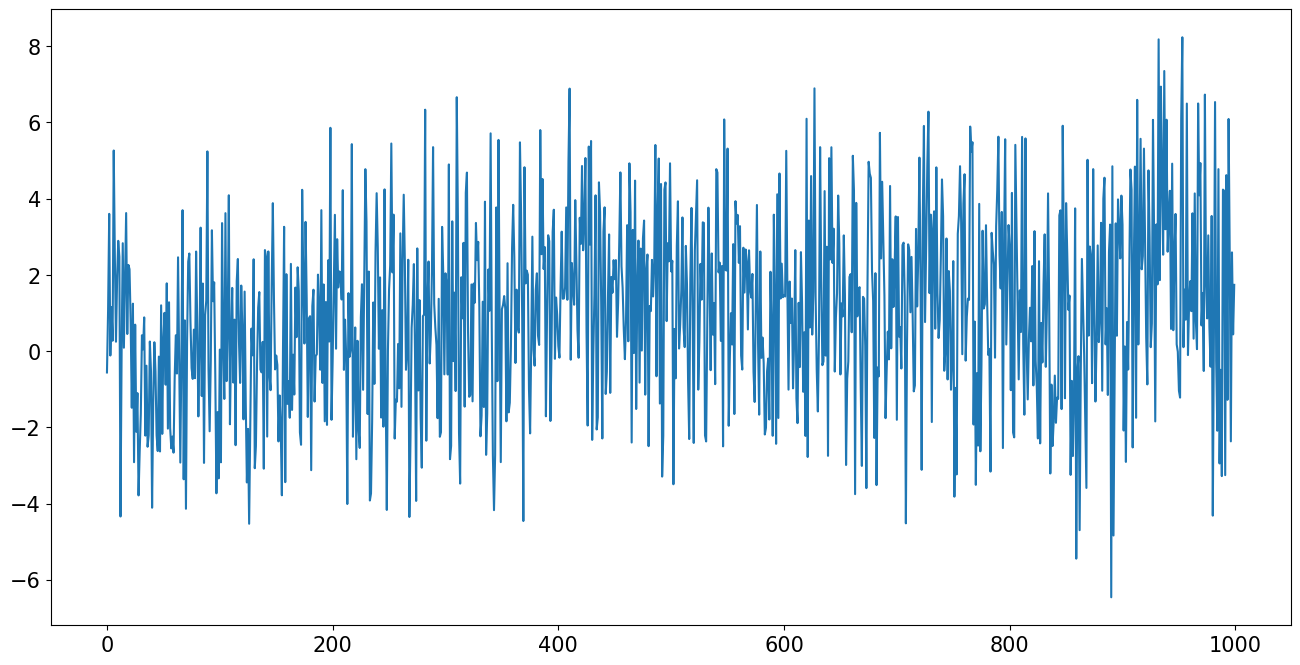

In [188]:
def gen_data_for_model1():
    nobs = 1000

    rs = np.random.RandomState(seed=93572)

    d = 0
    var_y = 5
    var_coeff_x = 0.01

    x_t = rs.uniform(size=nobs)
    eps = rs.normal(scale=var_y ** 0.5, size=nobs)

    beta_x = np.cumsum(rs.normal(size=nobs, scale=var_coeff_x ** 0.5))
   
    y_t = d + beta_x * x_t + eps
    return y_t, x_t, beta_x


y_t, x_t, beta_x = gen_data_for_model1()
_ = plt.plot(y_t)

In [189]:
mod = TVRegression(y_t, x_t)
res = mod.fit()

print(res.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.25248D+00    |proj g|=  3.73174D-01

At iterate    5    f=  2.24360D+00    |proj g|=  8.34926D-03

At iterate   10    f=  2.24221D+00    |proj g|=  9.38916D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     10     13      1     0     0   9.389D-06   2.242D+00
  F =   2.2422117408457916     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                           Statespace Model Results                   

 This problem is unconstrained.


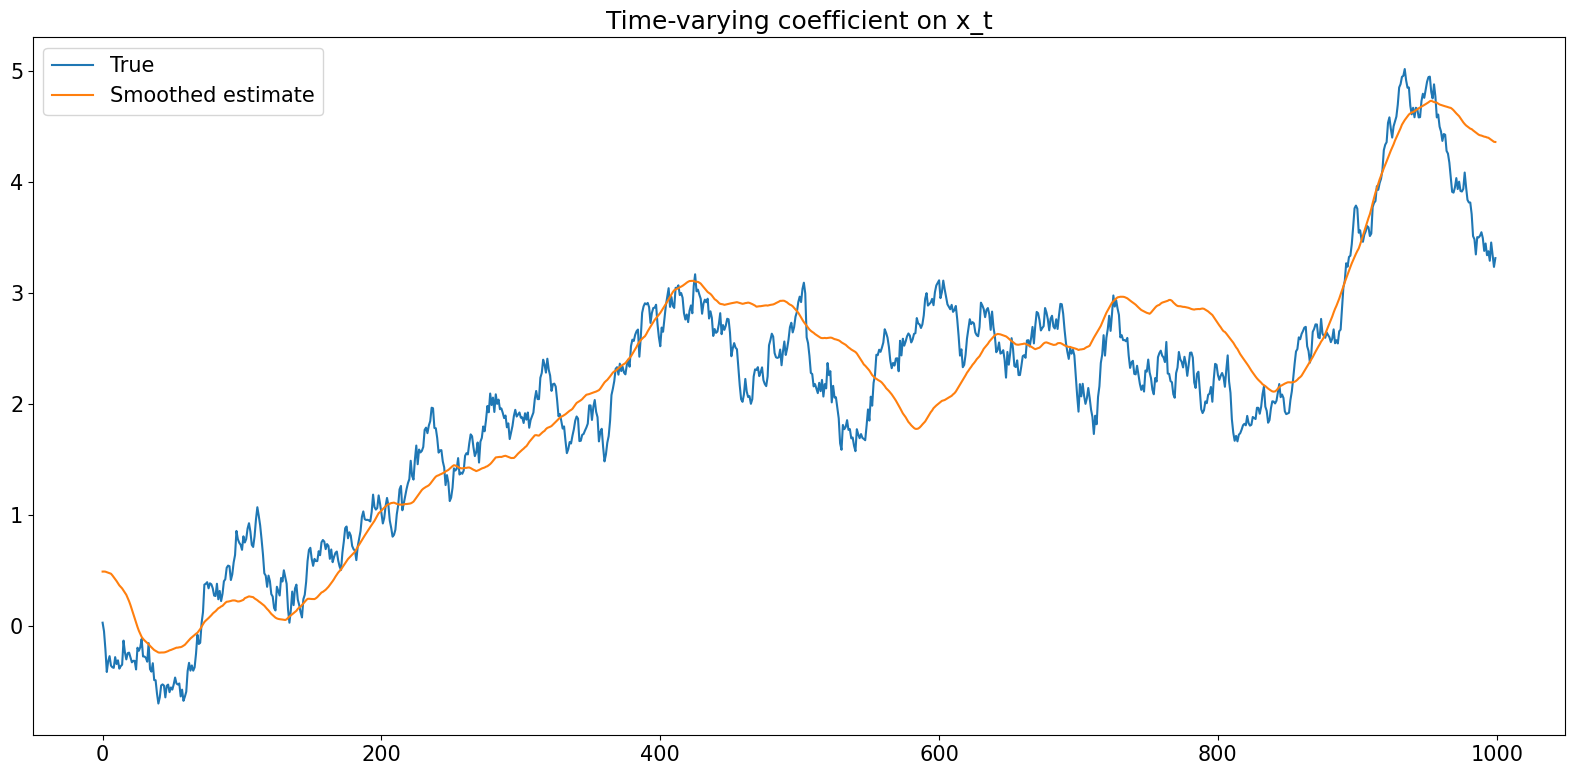

In [190]:
fig, axes = plt.subplots(1, figsize=(16, 8))

ss = pd.DataFrame(res.smoothed_state.T, columns=["x"])

axes.plot(beta_x, label="True")
axes.plot(ss["x"], label="Smoothed estimate")
axes.set(title="Time-varying coefficient on x_t")
axes.legend()

fig.tight_layout();

We see that the model fits the beta accuratly on simulated data. Means that nothing in the fitting alog has been messed up.

## Real Data

I start by using the TVRegression class as a baseline for my implementation. For many of my assumptions I will be referring to (Adrian, Franzoni 2004) and their formulation of a model for estimative CAPM for corner portfolios via Kalman filter. We see that in (Adrian, Franzoni 2004) the constant is ommitted from the model when measuring CAPM to maximize the effects of the MLE fitting, and show that the model is insensitive to the omission of an intercept. Thus, I choose a similar approach here. 

For portfolio and market data I will be refering to the monthly portfolio dataset provided in 230A that already comes with a mrket and risk free retun.


https://www.newyorkfed.org/medialibrary/media/research/staff_reports/sr193.pdf

In [191]:
data = pd.read_csv('Factors.csv')
data['Ex'] = data['Market'] - data['Rf']
data = data.set_index('Unnamed: 0')

In [192]:
results = {}
for i in ['Small-Low', 'Small-High', 'Big-Low', 'Big-High']:

    mod = TVRegression(data[i], data['Ex'])
    res = mod.fit()
    results[i] = (res, res.summary())

/home/lema/.pyenv/versions/3.11.9/envs/mfe3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/lema/.pyenv/versions/3.11.9/envs/mfe3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/lema/.pyenv/versions/3.11.9/envs/mfe3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.62453D+00    |proj g|=  1.04796D-01

At iterate    5    f=  2.62400D+00    |proj g|=  1.41442D-02

At iterate   10    f=  2.62107D+00    |proj g|=  4.07875D-02

At iterate   15    f=  2.62044D+00    |proj g|=  2.44465D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     16     20      1     0     0   3.775D-07   2.620D+00
  F =   2.6204422846744495     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/home/lema/.pyenv/versions/3.11.9/envs/mfe3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


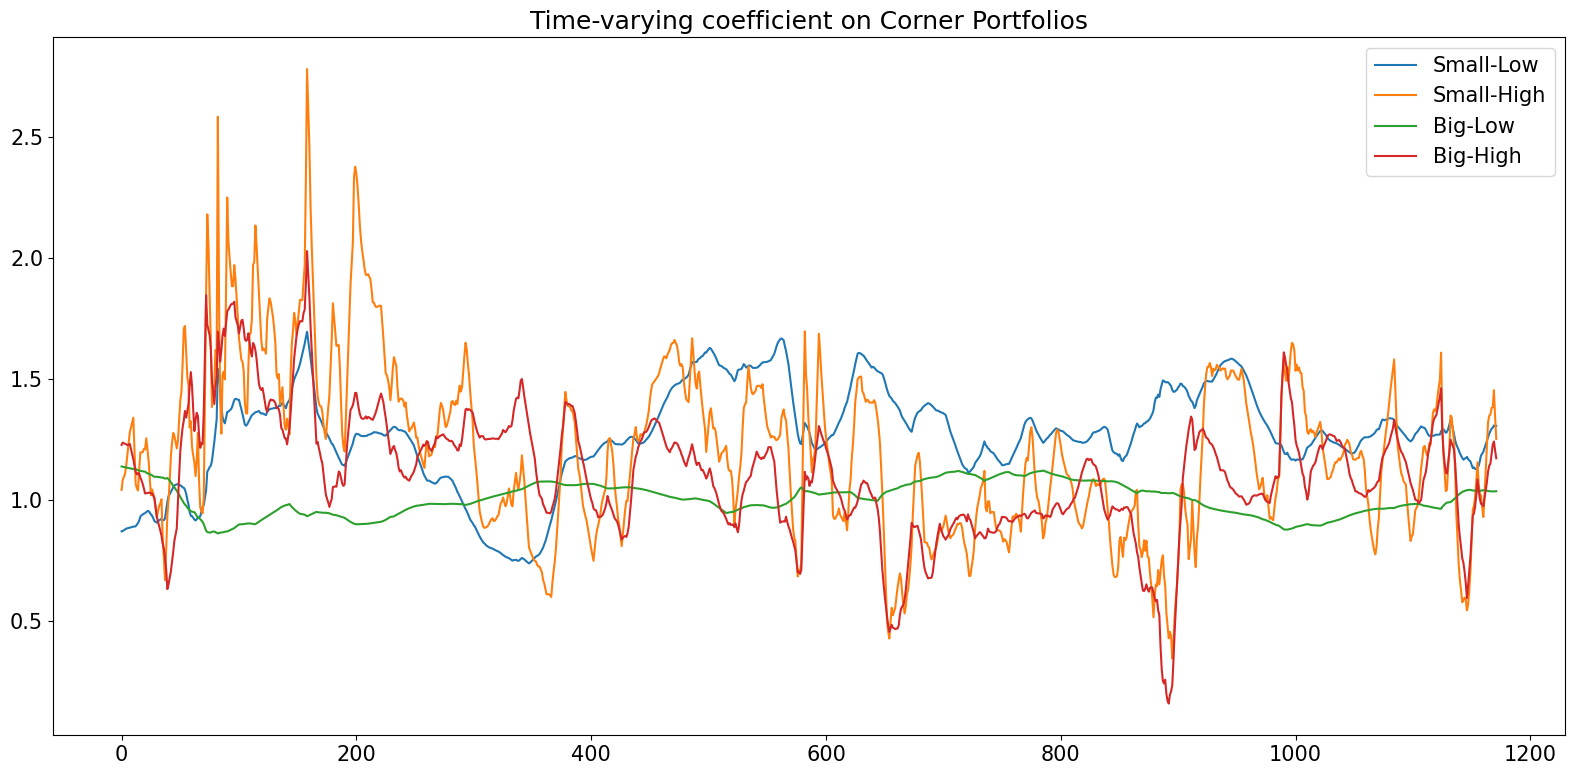

In [193]:
fig, axes = plt.subplots(1, figsize=(16, 8))

for i in ['Small-Low', 'Small-High', 'Big-Low', 'Big-High']:
    ss = pd.DataFrame(results[i][0].smoothed_state.T, columns=["x"])
    
    axes.plot(ss["x"], label=i)
    
axes.set(title="Time-varying coefficient on Corner Portfolios")
    
axes.legend(results.keys())

fig.tight_layout();

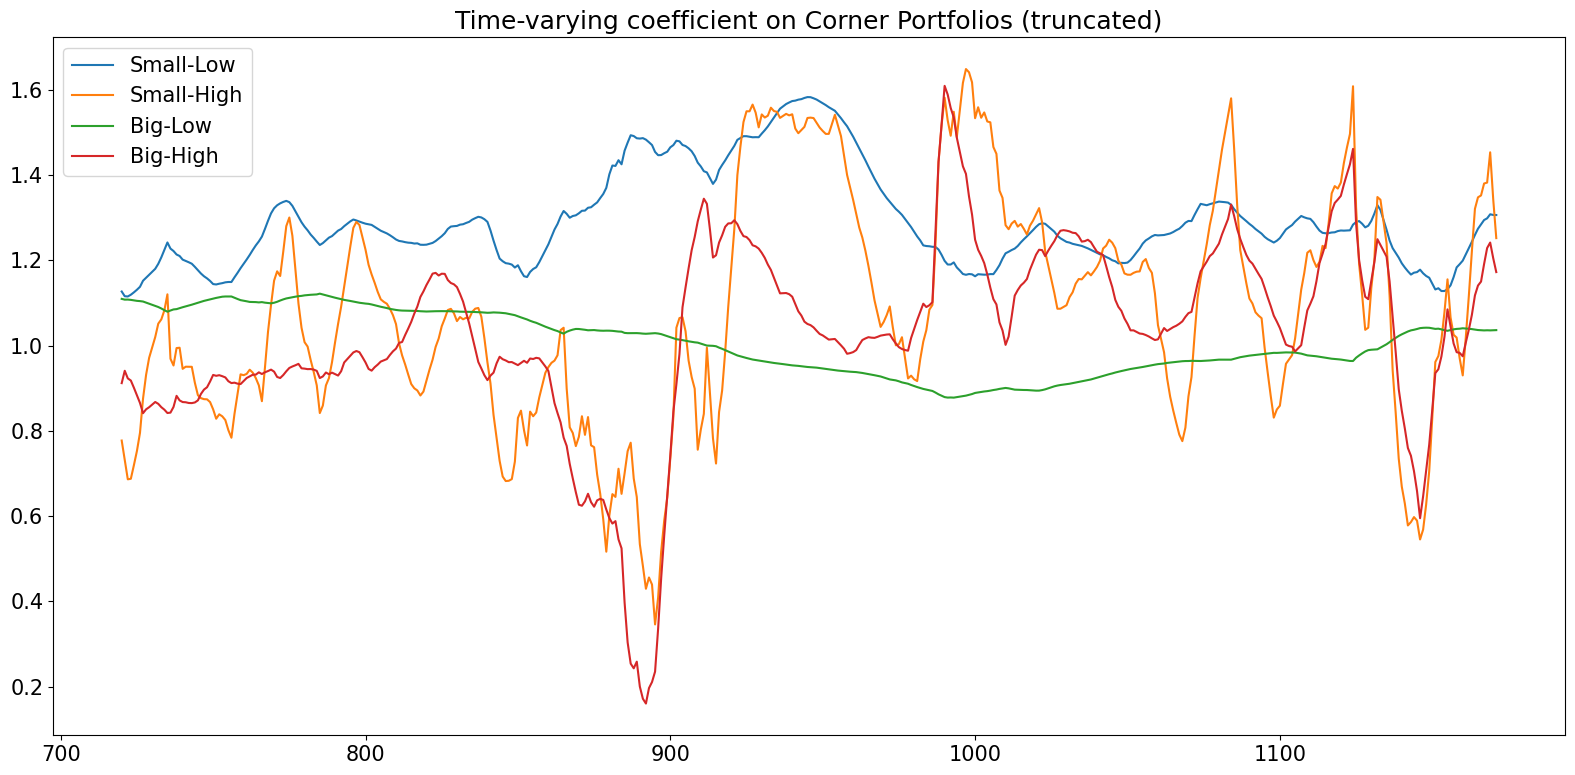

In [194]:
fig, axes = plt.subplots(1, figsize=(16, 8))

for i in ['Small-Low', 'Small-High', 'Big-Low', 'Big-High']:
    ss = pd.DataFrame(results[i][0].smoothed_state.T, columns=["x"])
    
    axes.plot(ss["x"][-452:], label=i)
    
axes.set(title="Time-varying coefficient on Corner Portfolios (truncated)")
    
axes.legend(results.keys())

fig.tight_layout();

We see that 

In [195]:
IBM = yf.download('IBM', start='1970-01-01', end='2024-04-26')['Adj Close']
MSFT = yf.download('MSFT', start='1970-01-01', end='2024-04-26')['Adj Close']

monthly_IBM = IBM.resample('ME').last()
monthly_MSFT = MSFT.resample('ME').last()

monthly_IBM=np.log(monthly_IBM/monthly_IBM.shift(1))[1:]*100
monthly_MSFT=np.log(monthly_MSFT/monthly_MSFT.shift(1))[1:]*100


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [196]:
monthly_IBM.index = [int(i.strftime('%Y%m')) for i in monthly_IBM.index]
monthly_MSFT.index = [int(i.strftime('%Y%m')) for i in monthly_MSFT.index]

In [197]:
monthly_MSFT.name = 'MSFT'
monthly_IBM.name = 'IBM'

In [198]:
data = data.join(monthly_MSFT)
data = data.join(monthly_IBM)

In [199]:
data_nona = data.dropna()
results2 = {}

for i in ['MSFT', 'IBM']:
    mod = TVRegression(data_nona[i], data_nona['Ex'])
    res = mod.fit()
    results2[i] = (res, res.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.44507D+00    |proj g|=  7.29283D-02

At iterate    5    f=  3.44469D+00    |proj g|=  1.67540D-04

At iterate   10    f=  3.44469D+00    |proj g|=  1.02200D-02

At iterate   15    f=  3.44460D+00    |proj g|=  6.82876D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     17     23      1     0     0   4.208D-06   3.445D+00
  F =   3.4445965330557278     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

/home/lema/.pyenv/versions/3.11.9/envs/mfe3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/lema/.pyenv/versions/3.11.9/envs/mfe3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


In [201]:
results2['MSFT']

(<statsmodels.tsa.statespace.mlemodel.MLEResultsWrapper at 0x7c4ceac33e90>,
 <class 'statsmodels.iolib.summary.Summary'>
 """
                            Statespace Model Results                           
 Dep. Variable:                   MSFT   No. Observations:                  455
 Model:                   TVRegression   Log Likelihood               -1567.291
 Date:                Mon, 06 May 2024   AIC                           3140.583
 Time:                        19:53:43   BIC                           3152.944
 Sample:                             0   HQIC                          3145.453
                                 - 455                                         
 Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
 -------------------------------------------------------------------------------
 var.e          56.4687      2.588     21.820      0.000      51.396    

In [202]:
results2['IBM']

(<statsmodels.tsa.statespace.mlemodel.MLEResultsWrapper at 0x7c4cf83e2f50>,
 <class 'statsmodels.iolib.summary.Summary'>
 """
                            Statespace Model Results                           
 Dep. Variable:                    IBM   No. Observations:                  455
 Model:                   TVRegression   Log Likelihood               -1482.233
 Date:                Mon, 06 May 2024   AIC                           2970.466
 Time:                        19:53:43   BIC                           2982.827
 Sample:                             0   HQIC                          2975.336
                                 - 455                                         
 Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
 -------------------------------------------------------------------------------
 var.e          37.7668      1.782     21.189      0.000      34.273    

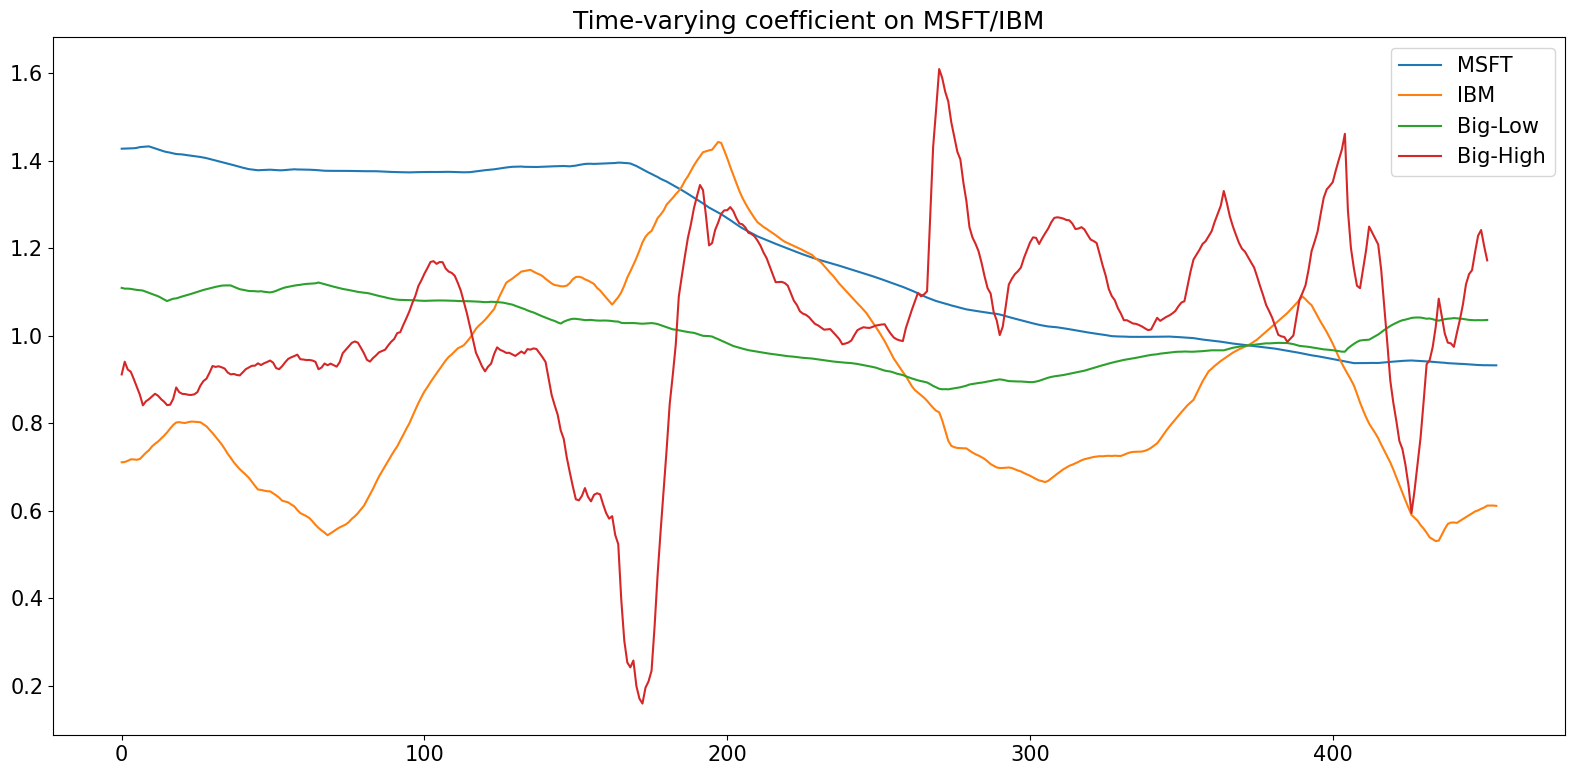

In [213]:
fig, axes = plt.subplots(1, figsize=(16, 8))

for i in ['MSFT', 'IBM']:
    ss = pd.DataFrame(results2[i][0].smoothed_state.T, columns=["x"])
    
    axes.plot(ss["x"], label=i)

for i in ['Big-Low', 'Big-High']:
    ss = pd.DataFrame(results[i][0].smoothed_state.T, columns=["x"])
    
    axes.plot(range(452), ss["x"][-452:], label=i)
    
axes.set(title="Time-varying coefficient on MSFT/IBM")
    
axes.legend(list(results2.keys()) + ['Big-Low', 'Big-High'])

fig.tight_layout();

We see that the Beta for IBM generally follow a similar pattern and magnitude as in the lecture slides (as a sanity check).

We see that MSFT is most similar to Big-Low portfolio, while IBM is similar to Big-High although not very.

We see that for Microsoft the beta is generaly quite stable like it is for the Big-Low portfolio. Makes sense as MSFT is generally seen as a growth stock.

For IBM we see the opposite, its an older company, and not as innovative as other tech giants have been. This makes IBM more of a value stock, meaning the alingment with Big-High is justified. It's not super alligned because IBM seems to swing between growth and value depending on what the company does.
